# Ноутбук для соревнования. Тема: _Mental Health_
### Создание модели

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Импортируем обработанные данные
train_data = pd.read_csv('data/processed_train.csv')

Мы заполнили пропуски, можно приступить к новому этапу. Теперь нужно представить данные в численном виде

In [43]:
# Удаляем имена и города
train_data = train_data.drop(['Name', 'City'], axis=1)

In [44]:
# Изменим бинарные столбцы на столбцы с 0 и 1
train_data.Gender = (train_data.Gender == 'Male').astype(int)
train_data['Working Professional or Student'] = (train_data['Working Professional or Student'] == 
                                                 'Working Professional').astype(int)
train_data['Have you ever had suicidal thoughts ?'] = (train_data['Have you ever had suicidal thoughts ?'] == 
                                                       'Yes').astype(int)
train_data['Family History of Mental Illness'] = (train_data['Family History of Mental Illness'] == 
                                                  'Yes').astype(int)

Заменим периоды сна на 1-4 в соответствии с его количеством.

In [45]:
train_data.loc[train_data['Sleep Duration'] == 'Less than 5 hours', 'Sleep Duration'] = 1
train_data.loc[train_data['Sleep Duration'] == '5-6 hours', 'Sleep Duration'] = 2
train_data.loc[train_data['Sleep Duration'] == '7-8 hours', 'Sleep Duration'] = 3
train_data.loc[train_data['Sleep Duration'] == 'More than 8 hours', 'Sleep Duration'] = 4

В целом, нам не важно какие именно бакалавры или магистры, поэтому заменим на более общие названия: `Bachelor` и `Master`. 

In [46]:
# Бакалавриат
bachelor_degrees = ["BHM", "LLB", "B.Pharm", "BBA", "BSc", "B.Arch",
                    "BCA", "BE", "B.Com", "BA", "B.Tech", "MBBS", "B.Ed"]

# Магистратура
master_degrees = ["MCA", "MD", "MA", "MBA", "M.Com", "MHM", "M.Tech",
                  "M.Ed", "MSc", "M.Pharm", "M.Arch", "LLM", "M.S", "ME"]

train_data.loc[train_data.Degree.isin(bachelor_degrees), 'Degree'] = 'Bachelor' 
train_data.loc[train_data.Degree.isin(master_degrees), 'Degree'] = 'Master' 

Отранжируем степени образования от K.Ed = 1, до PhD = 6.

In [47]:
train_data.loc[train_data.Degree == 'K.Ed', 'Degree'] = 1
train_data.loc[train_data.Degree == 'Class 12', 'Degree'] = 2
train_data.loc[train_data.Degree == 'Bachelor', 'Degree'] = 3
train_data.loc[train_data.Degree == 'P.Com', 'Degree'] = 4
train_data.loc[train_data.Degree == 'Master', 'Degree'] = 5
train_data.loc[train_data.Degree == 'PhD', 'Degree'] = 6

Теперь используем `One-Hot-Encodding` для `Dietary Habits`.

In [48]:
train_data = pd.get_dummies(train_data, columns=['Dietary Habits'])

In [60]:
from category_encoders.helmert import HelmertEncoder

encoder = HelmertEncoder(cols=['Profession'], drop_invariant=True)
encoded_data = encoder.fit_transform(train_data.drop('Depression', axis=1))
encoded_data.merge

C:\Users\79773\Desktop\Kaggle-Competition\.venv\lib\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
C:\Users\79773\Desktop\Kaggle-Competition\.venv\lib\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [62]:
obj_features = train_data.select_dtypes(include=['object', bool]).columns
train_data[obj_features] = train_data[obj_features].astype(int)

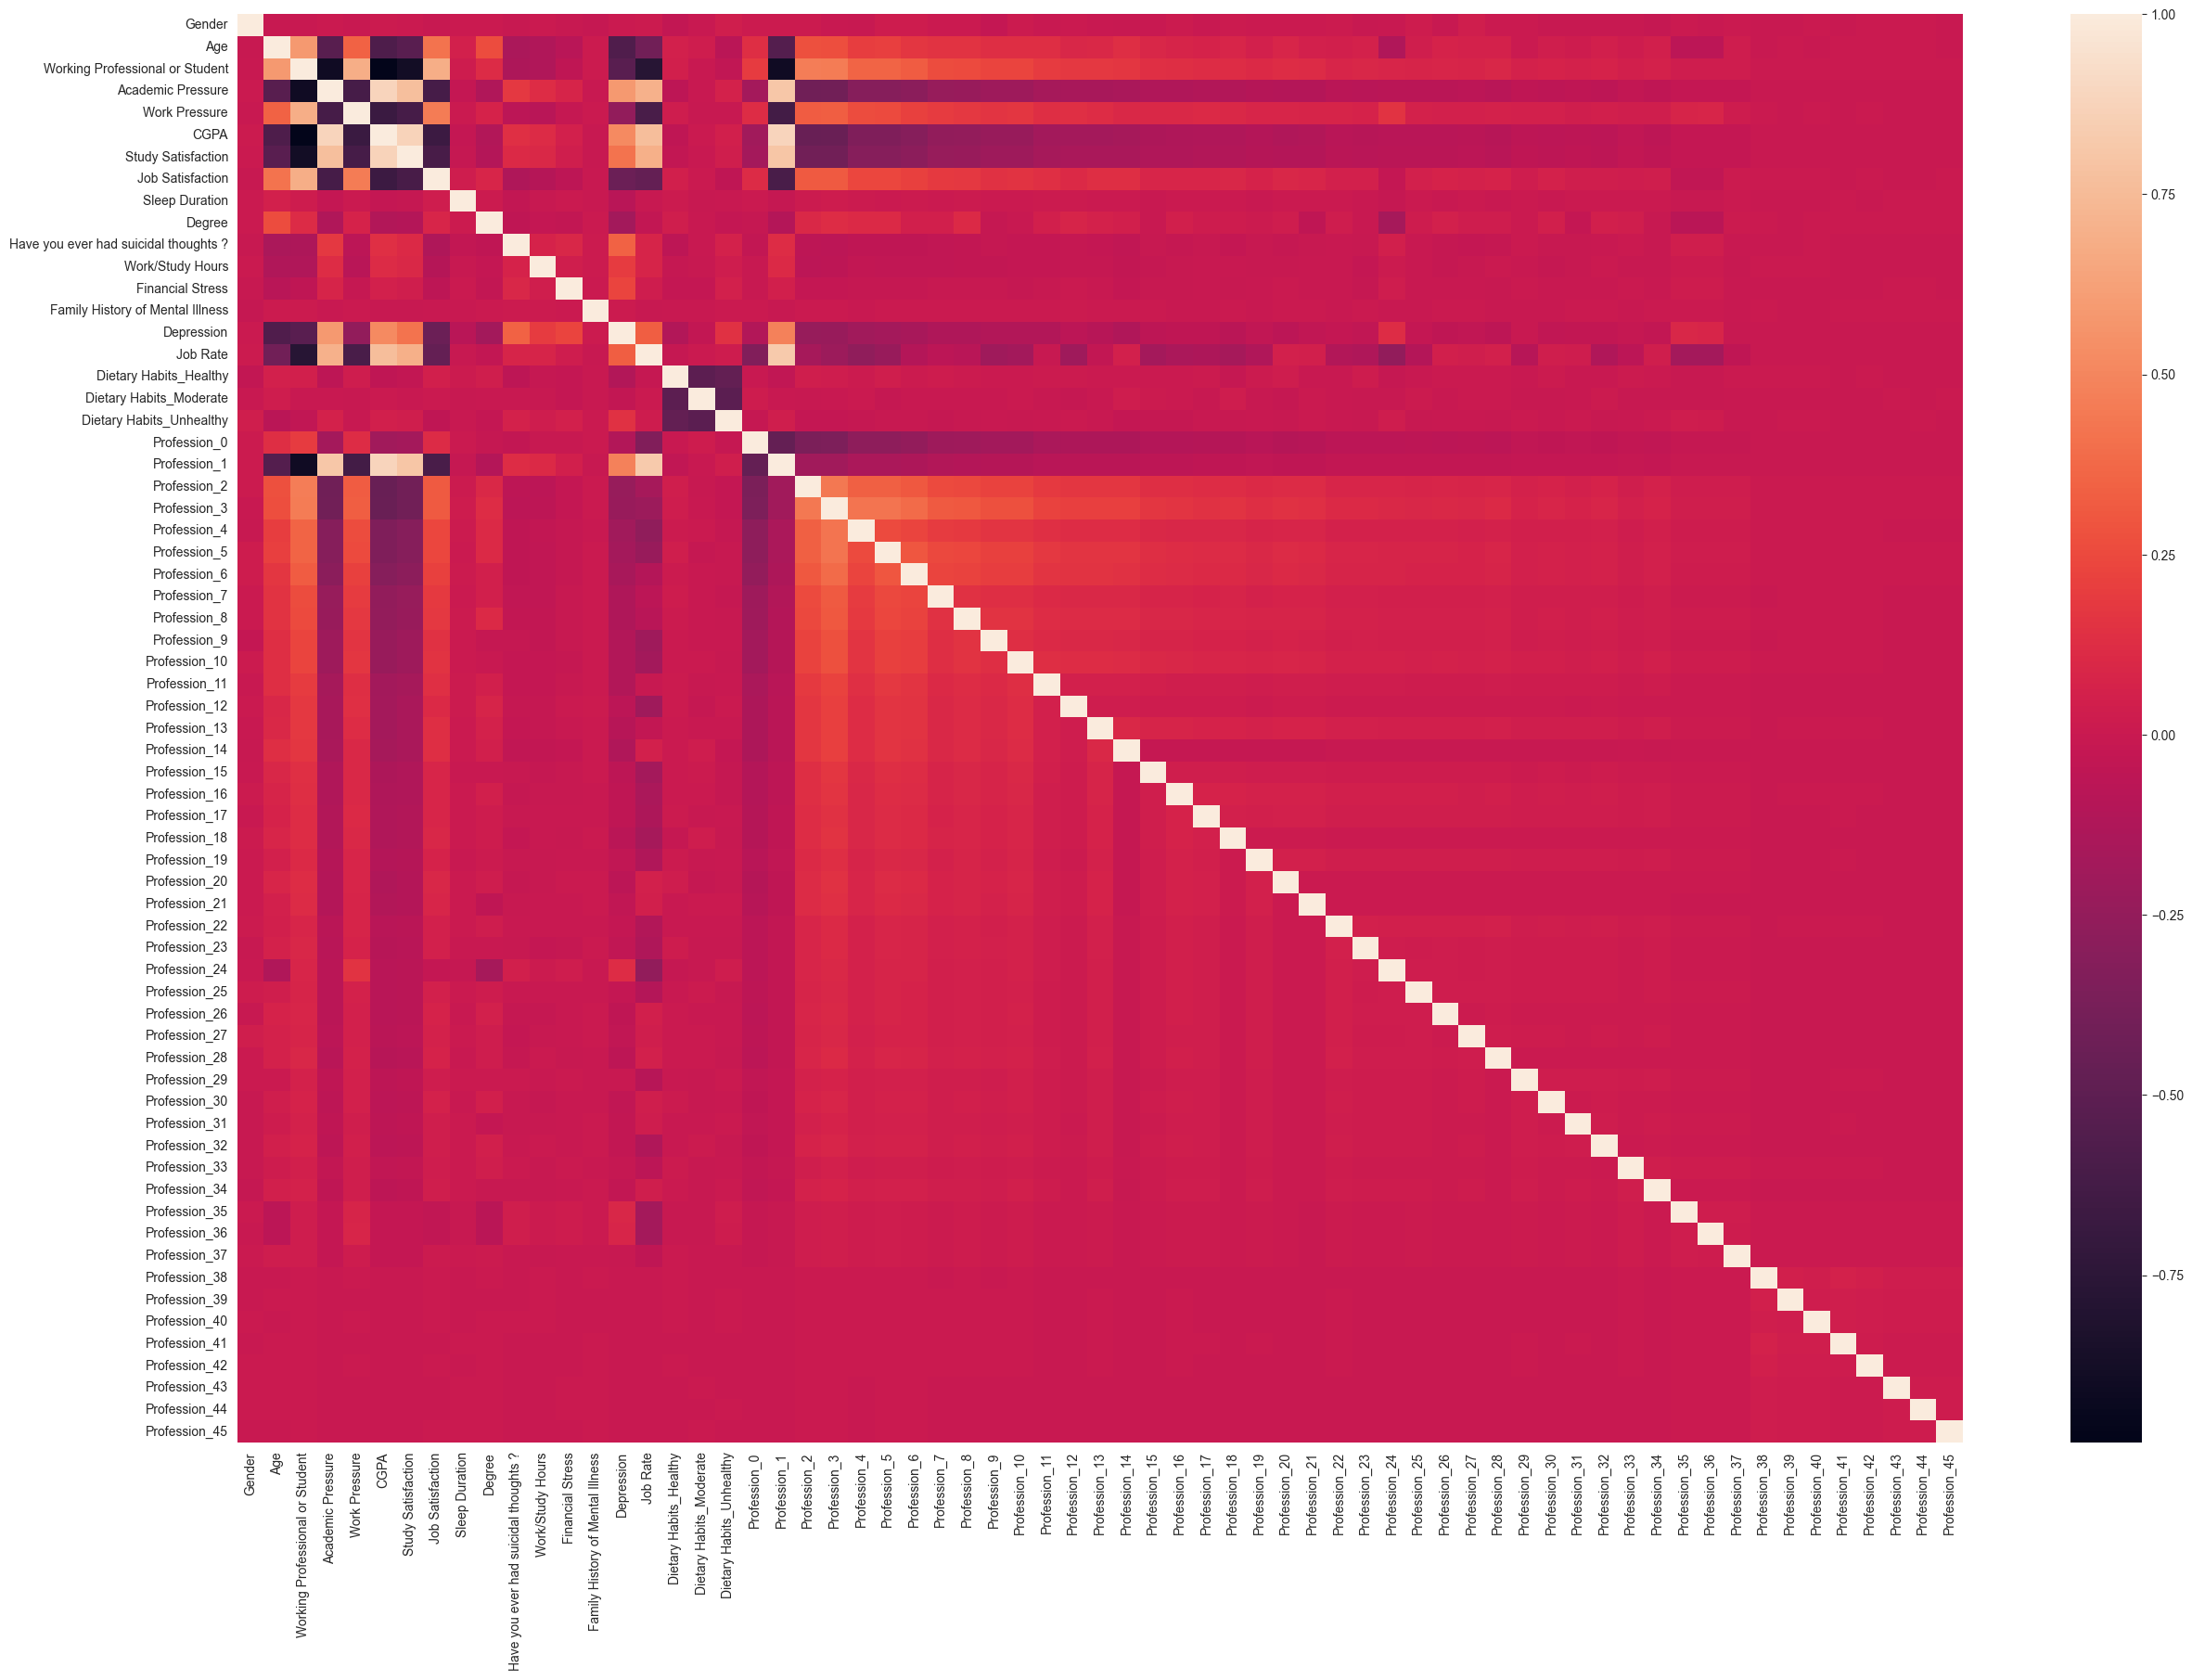

In [63]:
corr_matrix = train_data.corr()

plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix);

# Modeling

Для начала разделим на обучающую и тренировочную выборку.

In [64]:
from sklearn.model_selection import train_test_split

training_data, validation_data = train_test_split(train_data, test_size=0.1, random_state=42)

## DummyClassifier
Это будет Baseline модель.

In [65]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# Baseline модель
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(training_data.drop('Depression', axis=1), training_data['Depression'])

y_true = validation_data['Depression']
y_pred_dummy = dummy_classifier.predict(validation_data.drop('Depression', axis=1))

print(f'Accuracy baseline модели: {accuracy_score(y_true, y_pred_dummy)}\n')
print(classification_report(y_true, y_pred_dummy, zero_division=0, digits=4))  # Дополнительно посмотрим на остальные оценки

Accuracy baseline модели: 0.8181947405828003

              precision    recall  f1-score   support

           0     0.8182    1.0000    0.9000     11512
           1     0.0000    0.0000    0.0000      2558

    accuracy                         0.8182     14070
   macro avg     0.4091    0.5000    0.4500     14070
weighted avg     0.6694    0.8182    0.7364     14070



In [66]:
from sklearn.metrics import make_scorer, roc_auc_score
from skopt.space import Integer, Real
from skopt import BayesSearchCV

# В оптимизаторе используем roc_auc_score
roc_auc_scorer = make_scorer(roc_auc_score)

## CatBoostClassifier + BayesSearchCV

In [445]:
from catboost import CatBoostClassifier

catboost_param_space = {
    'iterations': Integer(100, 1000),
    'learning_rate': Real(3e-5, 0.5),
    'depth': Integer(5, 12),
    'border_count': Integer(128, 256),
    'random_strength': Real(0.3, 1),
    'l2_leaf_reg': Real(0.5, 10),
}

catboost_searcher = BayesSearchCV(CatBoostClassifier(loss_function='Logloss', verbose=False), 
                                  catboost_param_space, scoring=roc_auc_scorer, n_iter=30, cv=10, verbose=3)
catboost_searcher.fit(training_data.drop('Depression', axis=1), training_data['Depression'])

catboost_classifier = catboost_searcher.best_estimator_
print(f'Лучший показатель cross-validation модели CatBoost: {catboost_searcher.best_score_}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END border_count=250, depth=8, iterations=259, l2_leaf_reg=1.540703519121761, learning_rate=0.023494991204405284, random_strength=0.9862651655242514;, score=0.891 total time=  15.6s
[CV 2/10] END border_count=250, depth=8, iterations=259, l2_leaf_reg=1.540703519121761, learning_rate=0.023494991204405284, random_strength=0.9862651655242514;, score=0.884 total time=  15.9s
[CV 3/10] END border_count=250, depth=8, iterations=259, l2_leaf_reg=1.540703519121761, learning_rate=0.023494991204405284, random_strength=0.9862651655242514;, score=0.896 total time=   8.7s
[CV 4/10] END border_count=250, depth=8, iterations=259, l2_leaf_reg=1.540703519121761, learning_rate=0.023494991204405284, random_strength=0.9862651655242514;, score=0.887 total time=  11.7s
[CV 5/10] END border_count=250, depth=8, iterations=259, l2_leaf_reg=1.540703519121761, learning_rate=0.023494991204405284, random_strength=0.9862651655242514;, score=0.89

In [446]:
# Подбор порога
proba_catboost = catboost_classifier.predict_proba(validation_data.drop('Depression', axis=1))[:, 1]

thresholds = np.linspace(0.3, 0.7, 4000)
catboost_accuracies = []
for thr in thresholds:
    catboost_accuracies.append(accuracy_score(y_true, proba_catboost > thr))

catboost_threshold = thresholds[np.argmax(catboost_accuracies)]

In [447]:
y_pred_catboost = proba_catboost > catboost_threshold

print(f'Accuracy CatBoost модели: {accuracy_score(y_true, y_pred_catboost)}\n')  
print(classification_report(y_true, y_pred_catboost, digits=4))

Accuracy CatBoost модели: 0.9427860696517413

              precision    recall  f1-score   support

           0     0.9604    0.9700    0.9652     11492
           1     0.8599    0.8216    0.8403      2578

    accuracy                         0.9428     14070
   macro avg     0.9101    0.8958    0.9027     14070
weighted avg     0.9420    0.9428    0.9423     14070



## XGBoostClassifier + BayesSearchCV

In [77]:
from xgboost import XGBClassifier

xgb_param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(1e-6, 1),
    'gamma': Real(0, 1),
    'subsample': Real(0.001, 1),
    'min_child_weight': Real(0, 1),
    'reg_lambda': Real(0, 1)
}

xgb_searcher = BayesSearchCV(XGBClassifier(objective='binary:logistic'),
                             xgb_param_space, scoring=roc_auc_scorer, n_iter=25, cv=10, verbose=3)
xgb_searcher.fit(training_data.drop('Depression', axis=1), training_data['Depression'])

xgb_classifier = xgb_searcher.best_estimator_

print(f'Лучший показатель cross-validation модели XGBoost: {xgb_searcher.best_score_}')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.27406193760164294, learning_rate=0.22349856560275425, max_depth=3, min_child_weight=0.6568755371191598, n_estimators=291, reg_lambda=0.926904938191811, subsample=0.6725389179990757;, score=0.893 total time=   3.9s
[CV 2/10] END gamma=0.27406193760164294, learning_rate=0.22349856560275425, max_depth=3, min_child_weight=0.6568755371191598, n_estimators=291, reg_lambda=0.926904938191811, subsample=0.6725389179990757;, score=0.897 total time=   2.2s
[CV 3/10] END gamma=0.27406193760164294, learning_rate=0.22349856560275425, max_depth=3, min_child_weight=0.6568755371191598, n_estimators=291, reg_lambda=0.926904938191811, subsample=0.6725389179990757;, score=0.887 total time=   3.0s
[CV 4/10] END gamma=0.27406193760164294, learning_rate=0.22349856560275425, max_depth=3, min_child_weight=0.6568755371191598, n_estimators=291, reg_lambda=0.926904938191811, subsample=0.6725389179990757;, score=0.898 total time=   

In [78]:
# Подбор порога
proba_xgb = xgb_classifier.predict_proba(validation_data.drop('Depression', axis=1))[:, 1]

thresholds = np.linspace(0.3, 0.7, 4000)
xgb_accuracies = []
for thr in thresholds:
    xgb_accuracies.append(accuracy_score(y_true, proba_xgb > thr))

xgb_threshold = thresholds[np.argmax(xgb_accuracies)]

In [82]:
y_pred_xgb = proba_xgb > xgb_threshold

print(f'Accuracy XGBoost модели: {accuracy_score(y_true, y_pred_xgb)}\n')  
print(classification_report(y_true, y_pred_xgb, digits=4))

Accuracy XGBoost модели: 0.9373134328358209

              precision    recall  f1-score   support

           0     0.9593    0.9643    0.9618     11512
           1     0.8355    0.8159    0.8256      2558

    accuracy                         0.9373     14070
   macro avg     0.8974    0.8901    0.8937     14070
weighted avg     0.9368    0.9373    0.9370     14070



# Fully-Connected Neural Network

In [80]:
from torch import nn
import torch.nn.functional as f
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

training_tensor_data = TensorDataset(t.Tensor(training_data.drop('Depression', axis=1).to_numpy()),
                                     t.Tensor(training_data['Depression'].to_numpy()))
validation_tensor_data = TensorDataset(t.Tensor(validation_data.drop('Depression', axis=1).to_numpy()),
                                       t.Tensor(validation_data['Depression'].to_numpy()))

NameError: name 't' is not defined

In [ ]:
def train(model, gadget, train_loader, test_loader, criterion, optimizer,
          num_epochs, scheduler = None, train_losses_list = None, test_losses_list = None):
    if train_losses_list is None and test_losses_list is None:
        train_losses_list = []
        test_losses_list = []

    for _ in trange(num_epochs):
        model.train()
        
        train_desc = round(train_losses_list[-1], 3) if len(train_losses_list) > 0 else np.nan
        for batch in tqdm(train_loader, desc=f'Последний train_loss: {train_desc}', leave=False):
            X_batch = batch[0].to(gadget)
            y_batch = batch[1].to(gadget)

            optimizer.zero_grad()

            logit = model(X_batch)
            loss = criterion(logit, y_batch)

            loss.backward()
            optimizer.step()

            train_losses_list.append(loss.item())

        if scheduler is not None:
            scheduler.step()

        model.eval()
        with t.no_grad():
            test_desc = round(test_losses_list[-1], 3) if len(test_losses_list) > 0 else np.nan
            for batch in tqdm(test_loader, desc=f'Последний test_loss: {test_desc}', leave=False):
                X_batch = batch[0].to(gadget)
                y_batch = batch[1].to(gadget)

                loss = criterion(model(X_batch), y_batch)
                test_losses_list.append(loss.item())

    return train_losses_list, test_losses_list

In [ ]:
class FCClassifier(nn.Module):
    def __init__(self):
        super(FCClassifier, self).__init__()
        
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)
        
        self.batch_norm = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.2)
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = f.relu(self.fc1(self.batch_norm(x))) 
        out = self.dropout(f.relu(self.fc2(out))) 
        out = f.relu(self.fc3(out))
        out = f.relu(self.fc4(out))
        out = self.fc5(out) 
        
        return out.squeeze(1)

In [ ]:
# Используем по возможности CUDA
device = 'cuda' if t.cuda.is_available() else 'cpu'
nn_classifier = FCClassifier().to(device)
nn_classifier.initialize_weights()

# Задаем гиперпараметры
learning_rate = 1e-4
batch_size = 25
step_size = 10
gamma = 0.33
epochs = 30

# Создаем DataLoader'ы
train_dataloader = DataLoader(training_tensor_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(validation_tensor_data, batch_size=batch_size, num_workers=0)

# Фиксируем функцию потерь и оптимизатор
loss_function = nn.BCEWithLogitsLoss()
optim = t.optim.Adam(nn_classifier.parameters(), lr=learning_rate)
sched = t.optim.lr_scheduler.StepLR(optim, step_size=step_size, gamma=gamma)

In [ ]:
# Обучение модели
train_losses, valid_losses = train(nn_classifier, device, train_dataloader, valid_dataloader, loss_function, 
                                   optim, epochs, sched)

In [ ]:
# Нарисуем графики потерь
plt.figure(figsize=(12, 5))

def plot_losses(losses: list, n_part: int, label: str):
    compacted_losses = [np.mean(losses[part * len(losses) // n_part: (part + 1) * len(losses) // n_part]) 
                        for part in range(n_part)]
    plt.plot(compacted_losses, label=label)

plt.title('Кривые потерь')

plot_losses(train_losses, n_part=epochs, label='Потери обучающей выборки')
plot_losses(valid_losses, n_part=epochs, label='Потери проверочной выборки')

plt.grid()
plt.legend()
plt.show();

In [ ]:
# Предсказываем вероятности
nn_classifier.eval()
proba_nn = []
with t.no_grad():
    for Xt_batch, yt_batch in valid_dataloader:
        prob = f.sigmoid(nn_classifier(Xt_batch.to(device)))
        proba_nn.append(prob.cpu())
        
proba_nn = np.hstack(proba_nn)

# Подбор порога
thresholds = np.linspace(0.3, 0.7, 4000)
nn_accuracies = []
for thr in thresholds:
    nn_accuracies.append(accuracy_score(y_true, proba_nn > thr))
    
nn_threshold = thresholds[np.argmax(nn_accuracies)]

In [ ]:
y_pred_nn = proba_nn > nn_threshold

print(f'Accuracy нейронной сети: {accuracy_score(y_true, y_pred_nn)}\n')
print(classification_report(y_true, y_pred_nn, digits=4))

Будем использовать XGBoost. Теперь подгоним тестовые данные под нужный формат и сделаем прогноз. Сначала дообучим модель

In [ ]:
model = XGBClassifier(objective='binary:logistic', **xgb_searcher.best_params_)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_vals = cross_val_score(model, train_data.drop('Depression', axis=1), train_data['Depression'], 
                             cv=10, verbose=3)

print(f'\nПоказатель cross-validation: {cross_vals.mean()} ± {cross_vals.std()}')

In [ ]:
model.fit(train_data.drop('Depression', axis=1), train_data['Depression'])

Теперь обработаем тестовый данные

In [ ]:
test_data = pd.read_csv('data/processed_test.csv')

indexes = pd.RangeIndex(start=140700, stop=140700 + len(test_data), step=1)
test_data.index = indexes

In [ ]:
test_data

In [ ]:
test_data = test_data.drop(['Name', 'City'], axis=1)

test_data.Gender = (test_data.Gender == 'Male').astype(int)
test_data['Working Professional or Student'] = (test_data['Working Professional or Student'] == 
                                                 'Working Professional').astype(int)
test_data['Have you ever had suicidal thoughts ?'] = (test_data['Have you ever had suicidal thoughts ?'] == 
                                                       'Yes').astype(int)
test_data['Family History of Mental Illness'] = (test_data['Family History of Mental Illness'] == 
                                                  'Yes').astype(int)

In [ ]:
test_data.loc[test_data['Sleep Duration'] == 'Less than 5 hours', 'Sleep Duration'] = 1
test_data.loc[test_data['Sleep Duration'] == '5-6 hours', 'Sleep Duration'] = 2
test_data.loc[test_data['Sleep Duration'] == '7-8 hours', 'Sleep Duration'] = 3
test_data.loc[test_data['Sleep Duration'] == 'More than 8 hours', 'Sleep Duration'] = 4

In [ ]:
test_data.loc[test_data.Degree.isin(bachelor_degrees), 'Degree'] = 'Bachelor' 
test_data.loc[test_data.Degree.isin(master_degrees), 'Degree'] = 'Master' 

In [ ]:
test_data.loc[test_data.Degree == 'K.Ed', 'Degree'] = 1
test_data.loc[test_data.Degree == 'Class 12', 'Degree'] = 2
test_data.loc[test_data.Degree == 'Bachelor', 'Degree'] = 3
test_data.loc[test_data.Degree == 'P.Com', 'Degree'] = 4
test_data.loc[test_data.Degree == 'Master', 'Degree'] = 5
test_data.loc[test_data.Degree == 'PhD', 'Degree'] = 6

In [ ]:
test_data = pd.get_dummies(test_data, columns=['Dietary Habits'])

In [ ]:
test_data = encoder.transform(test_data) 

In [ ]:
test_data[['Dietary Habits_Healthy', 'Dietary Habits_Moderate', 
            'Dietary Habits_Unhealthy']] = test_data[['Dietary Habits_Healthy','Dietary Habits_Moderate', 
                                                       'Dietary Habits_Unhealthy']].astype(int)

test_data[obj_features] = test_data[obj_features].astype(int)

In [ ]:
# Подбор порога
train_proba = model.predict_proba(train_data.drop('Depression', axis=1))[:, 1]

thresholds = np.linspace(0.3, 0.7, 4000)
accuracies = []
for thr in thresholds:
    accuracies.append(accuracy_score(train_data['Depression'], train_proba > thr))

threshold = thresholds[np.argmax(accuracies)]

In [ ]:
# Делаем предсказание
test_proba = model.predict_proba(test_data)[:, 1]
y_test_pred = test_proba > threshold

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Depression'] = y_test_pred.astype(int)

In [ ]:
submission

In [ ]:
# Сохраняем результаты
submission.to_csv('data/submission.csv', index=False)